In [1]:
from __future__ import division
import ROOT
from ROOT import gSystem, gInterpreter
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm import tqdm
import math
import gc
import os
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.22/02


In [5]:
gInterpreter.AddIncludePath("/home/joao/MG5_aMC_v2_8_1/Delphes/")
gInterpreter.AddIncludePath("/home/joao/MG5_aMC_v2_8_1/Delphes/external/")
gInterpreter.Declare('#include "/home/joao/MG5_aMC_v2_8_1/Delphes/classes/DelphesClasses.h"')
gInterpreter.Declare('#include "/home/joao/MG5_aMC_v2_8_1/Delphes/external/ExRootAnalysis/ExRootAnalysisLinkDef.h"')
gSystem.Load("/home/joao/MG5_aMC_v2_8_1/Delphes/libDelphes.so")

1

In [6]:
from ROOT import Tower, Track

In [7]:
Signal_jets = ROOT.TChain("Delphes")
#Z_plus_jets = ROOT.TChain("Delphes")

chain_list = [Signal_jets]

Events = {'A3_single_prod_160GeV':'/home/joao/MG5_aMC_v2_8_1/Signal_low_mass/Events/run_01/tag_1_delphes_events.root'
          #'Z_plus_jets':'/home/joao/Desktop/Artigos/BGL_project2p0/roots/Z_plus_jets.root'
         }
for i,j in enumerate(Events.items()):
    chain_list[i].Add(j[1])
    print('number of events {}:'.format(j[0]),chain_list[i].GetEntries())

number of events A3_single_prod_160GeV: 50000


In [8]:
Features = ['pt_l1', 'pt_l2', 'pt_jet1', 'pt_jet2', 'pt_jet3', 'pt_jet4',
            'E_l1', 'E_l2', 'E_j1', 'E_j2', 'E_j3', 'E_j4', 'eta_l1', 'eta_l2',
            'eta_j1', 'eta_j2', 'eta_j3', 'eta_j4', 'phi_l1', 'phi_l2',
            'phi_j1', 'phi_j2', 'phi_j3', 'phi_j4', 'MZ', 'pt_z', 'eta_z',
            'phi_z', 'M_j1j2', 'M_j1j3', 'M_j1j4', 'M_j2j3', 'M_j2j4',
            'M_j3j4', 'pt_j1j2', 'pt_j1j3', 'pt_j1j4', 'pt_j2j3',
            'pt_j2j4', 'pt_j3j4', 'eta_j1j2', 'eta_j1j3', 'eta_j1j4',
            'eta_j2j3', 'eta_j2j4', 'eta_j3j4', 'phi_j1j2', 'phi_j1j3',
            'phi_j1j4', 'phi_j2j3', 'phi_j2j4', 'phi_j3j4' ,'MH2_1',
            'MH2_2', 'MH2_3', 'MH2_4', 'MH2_5', 'MH2_6', 'MA3', 'pt_A3',
            'eta_A3', 'phi_A3', 'cos_j1j2', 'cos_j1j3', 'cos_j1j4',
            'cos_j2j3', 'cos_j2j4', 'cos_j3j4', 'cos_j1lep1',
            'cos_j1lep2', 'cos_j2lep1', 'cos_j2lep2', 'cos_j3lep1',
            'cos_j3lep2', 'cos_j4lep1', 'cos_j4lep2', 'cos_lep1lep2',
            'DR_j1j2', 'DR_j1j3', 'DR_j1j4', 'DR_j2j3', 'DR_j2j4',
            'DR_j3j4', 'DR_j1lep1', 'DR_j1lep2', 'DR_j2lep1', 'DR_j2lep2',
            'DR_j3lep1', 'DR_j3lep2', 'DR_j4lep1', 'DR_j4lep2',
            'DR_lep1lep2', 'DPhi_j1j2', 'DPhi_j1j3', 'DPhi_j1j4',
            'DPhi_j2j3', 'DPhi_j2j4', 'DPhi_j3j4', 'DPhi_j1lep1',
            'DPhi_j1lep2', 'DPhi_j2lep1', 'DPhi_j2lep2', 'DPhi_j3lep1',
            'DPhi_j3lep2', 'DPhi_j4lep1', 'DPhi_j4lep2', 'DPhi_lep1lep2',
            'DTheta_j1j2', 'DTheta_j1j3', 'DTheta_j1j4', 'DTheta_j2j3', 'DTheta_j2j4',
            'DTheta_j3j4', 'DTheta_j1lep1', 'DTheta_j1lep2', 'DTheta_j2lep1',
            'DTheta_j2lep2', 'DTheta_j3lep1', 'DTheta_j3lep2', 'DTheta_j4lep1',
            'DTheta_j4lep2', 'DTheta_lep1lep2', 'xs_weight']

for chain, proc in zip(chain_list,Events.items()):
    
    df = pd.DataFrame(columns=Features)

    for count, event in enumerate(tqdm(chain, total=chain.GetEntries())):

        if count == 5000:
            break
        
        out = np.empty((chain.GetEntries(),len(Features)))
        out.fill(np.nan)
        survived = 0
        
        #Get charged leptons (anti-muons and muons)
        muons_eta = list(filter(lambda Muons: np.abs(Muons.Eta) <= 2.47, event.Muon))
        muons = list(filter(lambda Muons: Muons.PT > 20, muons_eta))
        muons = sorted(muons, key=lambda Muon: Muon.PT, reverse=True)          
        
        list_muon = muons

        #Get charged leptons (anti-electrons and electrons)
        electrons_eta = list(filter(lambda Electrons: np.abs(Electrons.Eta) <= 2.47, event.Electron))
        electrons = list(filter(lambda Electrons: Electrons.PT > 20., electrons_eta))
        electrons = sorted(electrons, key=lambda Electron: Electron.PT, reverse=True)  

        list_electron = electrons
        
        list_charged_lep = electrons + muons

        #Get jets. One list with b-jets and another with the light jets

        jet_eta = list(filter(lambda x: abs(x.Eta) <= 2.5, event.Jet))
        jet_filt = list(filter(lambda x: x.PT>20., jet_eta))
        jet_filt_ord = sorted(jet_filt, key=lambda Jet:Jet.PT, reverse=True)
        list_jets = jet_filt_ord

#         bjets, ljets = [], []
#         nbjets = 0
#         for n in range(len(jet_filt_ord)):
#             if jet_filt_ord[n].BTag == 1:
#                 bjets.append(jet_filt_ord[n])
#                 nbjets += 1
#             else:
#                 ljets.append(jet_filt_ord[n])

#         list_bjets = bjets
#         list_light_jets = ljets
        
#         list_jets = ljets + bjets
        

        #Initialize the 4-vectors:
        LEP_vec_1 = ROOT.TLorentzVector()
        LEP_vec_2 = ROOT.TLorentzVector()        
        LIGHT_JET_vec_1 = ROOT.TLorentzVector()
        LIGHT_JET_vec_2 = ROOT.TLorentzVector()
        LIGHT_JET_vec_3 = ROOT.TLorentzVector()
        LIGHT_JET_vec_4 = ROOT.TLorentzVector()


        #Begin analysis
        if (len(list_jets) > 3 and len(list_charged_lep) > 1):

            ####################
            LEP_vec_1.SetPtEtaPhiE(list_charged_lep[0].P4().Pt(),list_charged_lep[0].Eta,
                                   list_charged_lep[0].Phi,list_charged_lep[0].P4().E())
            ####################
            LEP_vec_2.SetPtEtaPhiE(list_charged_lep[1].P4().Pt(),list_charged_lep[1].Eta,
                                   list_charged_lep[1].Phi,list_charged_lep[1].P4().E())
            ####################
            LIGHT_JET_vec_1.SetPtEtaPhiE(list_jets[0].P4().Pt(),list_jets[0].Eta,
                                         list_jets[0].Phi,list_jets[0].P4().E())
            ####################
            LIGHT_JET_vec_2.SetPtEtaPhiE(list_jets[1].P4().Pt(),list_jets[1].Eta,
                                         list_jets[1].Phi,list_jets[1].P4().E())
            ####################
            LIGHT_JET_vec_3.SetPtEtaPhiE(list_jets[2].P4().Pt(),list_jets[2].Eta,
                                         list_jets[2].Phi,list_jets[2].P4().E())
            ####################
            LIGHT_JET_vec_4.SetPtEtaPhiE(list_jets[3].P4().Pt(),list_jets[3].Eta,
                                         list_jets[3].Phi,list_jets[3].P4().E())



            #High-level observables from final states 
                    
            # ------- Transverse momentum -------
            pt_l1 = LEP_vec_1.Pt()
            pt_l2 = LEP_vec_2.Pt()
            pt_jet1 = LIGHT_JET_vec_1.Pt()
            pt_jet2 = LIGHT_JET_vec_2.Pt()
            pt_jet3 = LIGHT_JET_vec_3.Pt()
            pt_jet4 = LIGHT_JET_vec_4.Pt()

            
            # ------- Energy -------
            E_l1 = LEP_vec_1.E()
            E_l2 = LEP_vec_2.E()
            E_j1 = LIGHT_JET_vec_1.E()
            E_j2 = LIGHT_JET_vec_2.E()            
            E_j3 = LIGHT_JET_vec_3.E()
            E_j4 = LIGHT_JET_vec_4.E() 
            
            # ------- Pseudorapidity -------
            eta_l1 = LEP_vec_1.Eta()
            eta_l2 = LEP_vec_2.Eta()
            eta_j1 = LIGHT_JET_vec_1.Eta()
            eta_j2 = LIGHT_JET_vec_2.Eta()          
            eta_j3 = LIGHT_JET_vec_3.Eta()
            eta_j4 = LIGHT_JET_vec_4.Eta() 
            
            # ------- Azimuthal angle -------
            phi_l1 = LEP_vec_1.Phi()
            phi_l2 = LEP_vec_2.Phi()
            phi_j1 = LIGHT_JET_vec_1.Phi()
            phi_j2 = LIGHT_JET_vec_2.Phi()              
            phi_j3 = LIGHT_JET_vec_3.Phi()
            phi_j4 = LIGHT_JET_vec_4.Phi()    
            
            # ------- Reconstructed Z boson -------
            Z_VEC = LEP_vec_1 + LEP_vec_2
            
            MZ = Z_VEC.M()
            pt_z = Z_VEC.Pt()
            eta_z = Z_VEC.Eta()
            phi_z = Z_VEC.Phi()            

            # ------- Two-jet observables -------
            J1J2_VEC = LIGHT_JET_vec_1 + LIGHT_JET_vec_2
            J1J3_VEC = LIGHT_JET_vec_1 + LIGHT_JET_vec_3
            J1J4_VEC = LIGHT_JET_vec_1 + LIGHT_JET_vec_4
            J2J3_VEC = LIGHT_JET_vec_2 + LIGHT_JET_vec_3
            J2J4_VEC = LIGHT_JET_vec_2 + LIGHT_JET_vec_4
            J3J4_VEC = LIGHT_JET_vec_3 + LIGHT_JET_vec_4
            
            
            M_j1j2 = J1J2_VEC.M()
            M_j1j3 = J1J3_VEC.M()
            M_j1j4 = J1J4_VEC.M()
            M_j2j3 = J2J3_VEC.M()
            M_j2j4 = J2J4_VEC.M()
            M_j3j4 = J3J4_VEC.M()
            
            pt_j1j2 = J1J2_VEC.Pt()
            pt_j1j3 = J1J3_VEC.Pt()
            pt_j1j4 = J1J4_VEC.Pt()
            pt_j2j3 = J2J3_VEC.Pt()
            pt_j2j4 = J2J4_VEC.Pt()
            pt_j3j4 = J3J4_VEC.Pt()
            
            eta_j1j2 = J1J2_VEC.Eta()
            eta_j1j3 = J1J3_VEC.Eta()
            eta_j1j4 = J1J4_VEC.Eta()
            eta_j2j3 = J2J3_VEC.Eta()
            eta_j2j4 = J2J4_VEC.Eta()
            eta_j3j4 = J3J4_VEC.Eta() 
            
            phi_j1j2 = J1J2_VEC.Phi()
            phi_j1j3 = J1J3_VEC.Phi()
            phi_j1j4 = J1J4_VEC.Phi()
            phi_j2j3 = J2J3_VEC.Phi()
            phi_j2j4 = J2J4_VEC.Phi()
            phi_j3j4 = J3J4_VEC.Phi()
                                    
            # ------- H2 mass observables -------
            
            H2_VEC_1 = LIGHT_JET_vec_1 + LIGHT_JET_vec_2 + Z_VEC
            H2_VEC_2 = LIGHT_JET_vec_1 + LIGHT_JET_vec_3 + Z_VEC
            H2_VEC_3 = LIGHT_JET_vec_1 + LIGHT_JET_vec_4 + Z_VEC
            H2_VEC_4 = LIGHT_JET_vec_2 + LIGHT_JET_vec_3 + Z_VEC
            H2_VEC_5 = LIGHT_JET_vec_2 + LIGHT_JET_vec_4 + Z_VEC
            H2_VEC_6 = LIGHT_JET_vec_3 + LIGHT_JET_vec_4 + Z_VEC            

            MH2_1 = H2_VEC_1.M()
            MH2_2 = H2_VEC_2.M()            
            MH2_3 = H2_VEC_3.M()            
            MH2_4 = H2_VEC_4.M()            
            MH2_5 = H2_VEC_5.M()
            MH2_6 = H2_VEC_6.M()

            # ------- A3 scalar observables -------

            A3_vec = Z_VEC + LIGHT_JET_vec_1 + LIGHT_JET_vec_2 + LIGHT_JET_vec_3 + LIGHT_JET_vec_4
            
            MA3 = A3_vec.M()
            pt_A3 = A3_vec.Pt()
            eta_A3 = A3_vec.Eta()
            phi_A3 = A3_vec.Phi()            
     
            #Angular variables between final states
            #Three vectors for everything
            
            T3_light_jet1 = LIGHT_JET_vec_1.Vect()
            T3_light_jet2 = LIGHT_JET_vec_2.Vect()
            T3_light_jet3 = LIGHT_JET_vec_3.Vect()
            T3_light_jet4 = LIGHT_JET_vec_4.Vect()            
            T3_lep1 = LEP_vec_1.Vect()
            T3_lep2 = LEP_vec_2.Vect()

            # ------- Cossine of polar angle -------
            
            cos_j1j2 = np.cos(T3_light_jet1.Angle(T3_light_jet2))
            cos_j1j3 = np.cos(T3_light_jet1.Angle(T3_light_jet3))
            cos_j1j4 = np.cos(T3_light_jet1.Angle(T3_light_jet4))
            cos_j2j3 = np.cos(T3_light_jet2.Angle(T3_light_jet3))
            cos_j2j4 = np.cos(T3_light_jet2.Angle(T3_light_jet4))
            cos_j3j4 = np.cos(T3_light_jet3.Angle(T3_light_jet4))
            ##
            cos_j1lep1 = np.cos(T3_light_jet1.Angle(T3_lep1))
            cos_j1lep2 = np.cos(T3_light_jet1.Angle(T3_lep2))
            cos_j2lep1 = np.cos(T3_light_jet2.Angle(T3_lep1))
            cos_j2lep2 = np.cos(T3_light_jet2.Angle(T3_lep2))
            cos_j3lep1 = np.cos(T3_light_jet3.Angle(T3_lep1))
            cos_j3lep2 = np.cos(T3_light_jet3.Angle(T3_lep2))
            cos_j4lep1 = np.cos(T3_light_jet4.Angle(T3_lep1))
            cos_j4lep2 = np.cos(T3_light_jet4.Angle(T3_lep2))
            ##
            cos_lep1lep2 = np.cos(T3_lep1.Angle(T3_lep2))   

            # ------- Delta R -------          
            
            DR_j1j2 = LIGHT_JET_vec_1.DeltaR(LIGHT_JET_vec_2)
            DR_j1j3 = LIGHT_JET_vec_1.DeltaR(LIGHT_JET_vec_3)
            DR_j1j4 = LIGHT_JET_vec_1.DeltaR(LIGHT_JET_vec_4)
            DR_j2j3 = LIGHT_JET_vec_2.DeltaR(LIGHT_JET_vec_3)
            DR_j2j4 = LIGHT_JET_vec_2.DeltaR(LIGHT_JET_vec_4)
            DR_j3j4 = LIGHT_JET_vec_3.DeltaR(LIGHT_JET_vec_4)
            ##
            DR_j1lep1 = LIGHT_JET_vec_1.DeltaR(LEP_vec_1)
            DR_j1lep2 = LIGHT_JET_vec_1.DeltaR(LEP_vec_2)
            DR_j2lep1 = LIGHT_JET_vec_2.DeltaR(LEP_vec_1)
            DR_j2lep2 = LIGHT_JET_vec_2.DeltaR(LEP_vec_2)
            DR_j3lep1 = LIGHT_JET_vec_3.DeltaR(LEP_vec_1)
            DR_j3lep2 = LIGHT_JET_vec_3.DeltaR(LEP_vec_2)
            DR_j4lep1 = LIGHT_JET_vec_4.DeltaR(LEP_vec_1)
            DR_j4lep2 = LIGHT_JET_vec_4.DeltaR(LEP_vec_2)
            ##
            DR_lep1lep2 = LEP_vec_1.DeltaR(LEP_vec_2)                            
            
            # ------- Delta Phi -------
            DPhi_j1j2 = LIGHT_JET_vec_1.DeltaPhi(LIGHT_JET_vec_2)
            DPhi_j1j3 = LIGHT_JET_vec_1.DeltaPhi(LIGHT_JET_vec_3)
            DPhi_j1j4 = LIGHT_JET_vec_1.DeltaPhi(LIGHT_JET_vec_4)
            DPhi_j2j3 = LIGHT_JET_vec_2.DeltaPhi(LIGHT_JET_vec_3)
            DPhi_j2j4 = LIGHT_JET_vec_2.DeltaPhi(LIGHT_JET_vec_4)
            DPhi_j3j4 = LIGHT_JET_vec_3.DeltaPhi(LIGHT_JET_vec_4)
            ##
            DPhi_j1lep1 = LIGHT_JET_vec_1.DeltaPhi(LEP_vec_1)
            DPhi_j1lep2 = LIGHT_JET_vec_1.DeltaPhi(LEP_vec_2)
            DPhi_j2lep1 = LIGHT_JET_vec_2.DeltaPhi(LEP_vec_1)
            DPhi_j2lep2 = LIGHT_JET_vec_2.DeltaPhi(LEP_vec_2)
            DPhi_j3lep1 = LIGHT_JET_vec_3.DeltaPhi(LEP_vec_1)
            DPhi_j3lep2 = LIGHT_JET_vec_3.DeltaPhi(LEP_vec_2)
            DPhi_j4lep1 = LIGHT_JET_vec_4.DeltaPhi(LEP_vec_1)
            DPhi_j4lep2 = LIGHT_JET_vec_4.DeltaPhi(LEP_vec_2)
            ##
            DPhi_lep1lep2 = LEP_vec_1.DeltaPhi(LEP_vec_2)  
            
            # ------- Delta Theta -------
            DTheta_j1j2 = LIGHT_JET_vec_1.Theta() -  LIGHT_JET_vec_2.Theta()
            DTheta_j1j3 = LIGHT_JET_vec_1.Theta() - LIGHT_JET_vec_3.Theta()
            DTheta_j1j4 = LIGHT_JET_vec_1.Theta() - LIGHT_JET_vec_4.Theta()
            DTheta_j2j3 = LIGHT_JET_vec_2.Theta() - LIGHT_JET_vec_3.Theta()
            DTheta_j2j4 = LIGHT_JET_vec_2.Theta() - LIGHT_JET_vec_4.Theta()
            DTheta_j3j4 = LIGHT_JET_vec_3.Theta() - LIGHT_JET_vec_4.Theta()
            ##
            DTheta_j1lep1 = LIGHT_JET_vec_1.Theta() - LEP_vec_1.Theta()
            DTheta_j1lep2 = LIGHT_JET_vec_1.Theta() - LEP_vec_2.Theta()
            DTheta_j2lep1 = LIGHT_JET_vec_2.Theta() - LEP_vec_1.Theta()
            DTheta_j2lep2 = LIGHT_JET_vec_2.Theta() - LEP_vec_2.Theta()
            DTheta_j3lep1 = LIGHT_JET_vec_3.Theta() - LEP_vec_1.Theta()
            DTheta_j3lep2 = LIGHT_JET_vec_3.Theta() - LEP_vec_2.Theta()
            DTheta_j4lep1 = LIGHT_JET_vec_4.Theta() - LEP_vec_1.Theta()
            DTheta_j4lep2 = LIGHT_JET_vec_4.Theta() - LEP_vec_2.Theta()
            ##
            DTheta_lep1lep2 = LEP_vec_1.Theta() - LEP_vec_2.Theta()  

            # ------- Cross-section -------
            event_weight = [eevent.Weight for eevent in event.Event]
            xs_weight = event_weight[0] if len(event_weight) == 1 else 0
            

            # ------- List of all features -------
            Observables = [pt_l1, pt_l2, pt_jet1, pt_jet2, pt_jet3, pt_jet4,
                           E_l1, E_l2, E_j1, E_j2, E_j3, E_j4, eta_l1, eta_l2,
                           eta_j1, eta_j2, eta_j3, eta_j4, phi_l1, phi_l2,
                           phi_j1, phi_j2, phi_j3, phi_j4, MZ, pt_z, eta_z,
                           phi_z, M_j1j2, M_j1j3, M_j1j4, M_j2j3, M_j2j4,
                           M_j3j4, pt_j1j2, pt_j1j3, pt_j1j4, pt_j2j3,
                           pt_j2j4, pt_j3j4, eta_j1j2, eta_j1j3, eta_j1j4,
                           eta_j2j3, eta_j2j4, eta_j3j4, phi_j1j2, phi_j1j3,
                           phi_j1j4, phi_j2j3, phi_j2j4, phi_j3j4 ,MH2_1,
                           MH2_2, MH2_3, MH2_4, MH2_5, MH2_6, MA3, pt_A3,
                           eta_A3, phi_A3, cos_j1j2, cos_j1j3, cos_j1j4,
                           cos_j2j3, cos_j2j4, cos_j3j4, cos_j1lep1,
                           cos_j1lep2, cos_j2lep1, cos_j2lep2, cos_j3lep1,
                           cos_j3lep2, cos_j4lep1, cos_j4lep2, cos_lep1lep2,
                           DR_j1j2, DR_j1j3, DR_j1j4, DR_j2j3, DR_j2j4,
                           DR_j3j4, DR_j1lep1, DR_j1lep2, DR_j2lep1, DR_j2lep2,
                           DR_j3lep1, DR_j3lep2, DR_j4lep1, DR_j4lep2,
                           DR_lep1lep2, DPhi_j1j2, DPhi_j1j3, DPhi_j1j4,
                           DPhi_j2j3, DPhi_j2j4, DPhi_j3j4, DPhi_j1lep1,
                           DPhi_j1lep2, DPhi_j2lep1, DPhi_j2lep2, DPhi_j3lep1,
                           DPhi_j3lep2, DPhi_j4lep1, DPhi_j4lep2, DPhi_lep1lep2, DTheta_j1j2,
                           DTheta_j1j3, DTheta_j1j4, DTheta_j2j3, DTheta_j2j4,
                           DTheta_j3j4, DTheta_j1lep1, DTheta_j1lep2, DTheta_j2lep1,
                           DTheta_j2lep2, DTheta_j3lep1, DTheta_j3lep2, DTheta_j4lep1,
                           DTheta_j4lep2, DTheta_lep1lep2, xs_weight]

            entry = pd.DataFrame([Observables], columns=Features)
            df = df.append(entry)

            ###
            out[survived] = np.array(Observables)
            survived += 1
            
            df.to_csv('/home/joao/Desktop/Root-analysis/1-BGL-MLProject/Data/{f}.csv'.format(f=proc[0]),sep=',',index=False)

 10%|█         | 5000/50000 [02:48<25:18, 29.63it/s]  


# Plots

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd

In [2]:
Signal = pd.read_csv('/home/joao/Desktop/Root-analysis/1-BGL-MLProject/Data/A3_single_prod_160GeV.csv')
Z_plus_jets = pd.read_csv('/home/joao/Desktop/Root-analysis/1-BGL-MLProject/Data/Z_plus_jets.csv')

In [3]:
len(np.transpose(list(Signal)))

123

In [11]:
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{inputenc}'
plt.rcParams.update({'font.size': 90})

In [12]:
#Drop variables
Vars = ['xs_weight']
Signal = Signal.drop(Vars,axis=1)
Z_plus_jets = Z_plus_jets.drop(Vars,axis=1)

In [13]:
labels = ['$p_T(\\ell_1)$ (GeV)', '$p_T(\\ell_2)$ (GeV)', '$p_T(j_1)$ (GeV)', '$p_T(j_2)$ (GeV)', '$p_T(j_3)$ (GeV)', '$p_T(j_4)$ (GeV)',
            '$E(\\ell_1)$ (GeV)', '$E(\\ell_2)$ (GeV)', '$E(j_1)$ (GeV)', '$E(j_2)$ (GeV)', '$E(j_3)$ (GeV)', '$E(j_4)$ (GeV)', '$\\eta(\\ell_1)$', '$\\eta(\\ell_2)$',
            '$\\eta(j_1)$', '$\\eta(j_2)$', '$\\eta(j_3)$', '$\\eta(j_4)$', '$\\phi(\\ell_1)$', '$\\phi(\\ell_2)$',
            '$\\phi(j_1)$', '$\\phi(j_2)$', '$\\phi(j_3)$', '$\\phi(j_4)$', '$M_{\\mathrm{Z^0}}$ (GeV)', '$p_T(\\mathrm{Z^0})$ (GeV)', '$\\eta(\\mathrm{Z^0})$',
            '$\\phi(\\mathrm{Z^0})$', '$M_{j_1 j_2}$ (GeV)', '$M_{j_1 j_3}$ (GeV)', '$M_{j_1 j_4}$ (GeV)', '$M_{j_2 j_3}$ (GeV)', '$M_{j_2 j_4}$ (GeV)',
            '$M_{j_3 j_4}$ (GeV)', '$p_T(j_1 j_2)$ (GeV)', '$p_T(j_1 j_3)$ (GeV)', '$p_T(j_1 j_4)$ (GeV)', '$p_T(j_2 j_3)$ (GeV)',
            '$p_T(j_2 j_4)$ (GeV)', '$p_T(j_3 j_4)$ (GeV)', '$\\eta(j_1 j_2)$', '$\\eta(j_1 j_3)$', '$\\eta(j_1 j_4)$',
            '$\\eta(j_2 j_3)$', '$\\eta(j_2 j_4)$', '$\\eta(j_3 j_4)$', '$\\phi(j_1 j_2)$', '$\\phi(j_1 j_3)$',
            '$\\phi(j_1 j_4)$', '$\\phi(j_2 j_3)$', '$\\phi(j_2 j_4)$', '$\\phi(j_3 j_4)$' ,'$M(H_{2,1})$ (GeV)',
            '$M(H_{2,2})$ (GeV)', '$M(H_{2,3})$ (GeV)', '$M(H_{2,4})$ (GeV)', '$M(H_{2,5})$ (GeV)', '$M(H_{2,6})$ (GeV)', '$M(A_3)$ (GeV)', '$p_T(A_3)$ (GeV)',
            '$\\eta(A_3)$', '$\\phi(A_3)$', '$\cos(\\theta_{j_1 j_2})$', '$\cos(\\theta_{j_1 j_3})$', '$\cos(\\theta_{j_1 j_4})$',
            '$\cos(\\theta_{j_2 j_3})$', '$\cos(\\theta_{j_2 j_4})$', '$\cos(\\theta_{j_3 j_4})$', '$\cos(\\theta_{j_1 \\ell_1})$',
            '$\cos(\\theta_{j_1 \\ell_2})$', '$\cos(\\theta_{j_2 \\ell_1})$', '$\cos(\\theta_{j_2 \\ell_2})$', '$\cos(\\theta_{j_3 \\ell_1})$',
            '$\cos(\\theta_{j_3 \\ell_2})$', '$\cos(\\theta_{j_4 \\ell_1})$', '$\cos(\\theta_{j_4 \\ell_2})$', '$\cos(\\theta_{\\ell_1 \\ell_2})$',
            '$\\Delta R(j_1,j_2)$', '$\\Delta R(j_1,j_3)$', '$\\Delta R(j_1,j_4)$', '$\\Delta R(j_2,j_3)$', '$\\Delta R(j_2,j_4)$',
            '$\\Delta R(j_3,j_4)$', '$\\Delta R(j_1,\\ell_1)$', '$\\Delta R(j_1,\\ell_2)$', '$\\Delta R(j_2,\\ell_1)$', '$\\Delta R(j_2,\\ell_2)$',
            '$\\Delta R(j_3,\\ell_1)$', '$\\Delta R(j_3,\\ell_2)$', '$\\Delta R(j_4,\\ell_1)$', '$\\Delta R(j_4,\\ell_2)$',
            '$\\Delta R(\\ell_1,\\ell_2)$', '$\\Delta \\phi(j_1,j_2)$', '$\\Delta \\phi(j_1,j_3)$', '$\\Delta \\phi(j_1,j_4)$',
            '$\\Delta \\phi(j_2,j_3)$', '$\\Delta \\phi(j_2,j_4)$', '$\\Delta \\phi(j_3,j_4)$', '$\\Delta \\phi(j_1,\\ell_1)$',
            '$\\Delta \\phi(j_1,\\ell_2)$', '$\\Delta \\phi(j_2,\\ell_2)$', '$\\Delta \\phi(j_2,\\ell_2)$', '$\\Delta \\phi(j_3,\\ell_1)$',
            '$\\Delta \\phi(j_3,\\ell_2)$', '$\\Delta \\phi(j_4,\\ell_1)$', '$\\Delta \\phi(j_4,\\ell_2)$', '$\\Delta \\phi(\\ell_1,\\ell_2)$',
            '$\\Delta \\theta(j_1,j_2)$', '$\\Delta \\theta(j_1,j_3)$', '$\\Delta \\theta(j_1,j_4)$', '$\\Delta \\theta(j_2,j_3)$', '$\\Delta \\theta(j_2,j_4)$',
            '$\\Delta \\theta(j_3,j_4)$', '$\\Delta \\theta(j_1,\\ell_1)$', '$\\Delta \\theta(j_1,\\ell_2)$', '$\\Delta \\theta(j_2,\\ell_1)$',
            '$\\Delta \\theta(j_2,\\ell_2)$', '$\\Delta \\theta(j_3,\\ell_1)$', '$\\Delta \\theta(j_3,\\ell_2)$', '$\\Delta \\theta(j_4,\\ell_1)$',
            '$\\Delta \\theta(j_4,\\ell_2)$', '$\\Delta \\theta(\\ell_1,\\ell_2)$']

In [14]:
num_cols=4
N=len(labels)+1
fig, axes = plt.subplots(nrows=31,ncols=num_cols,figsize=(120,350))
fig.tight_layout(pad=5.0)
axes = axes.flatten()


for i, feature in enumerate(labels):

    var_signal = Signal.iloc[:,i]
    var_z_plus_jets = Z_plus_jets.iloc[:,i]

    var_signal.hist(ax=axes[i],bins=30,density=True,edgecolor='black',color='#b00505',histtype="stepfilled",label="Signal")
    var_z_plus_jets.hist(ax=axes[i],bins=30,density=True,edgecolor='#0216f0',color="#0216f0",histtype="step",label="$\\mathrm{Z^0+jets}$", linewidth=6.0)
    axes[i].set_xlabel(feature, labelpad = 10.0)
    axes[i].set_ylabel("NE (arb. units)", labelpad = 50.0)
        
        
fig.suptitle('\\textbf{All observables}',fontsize=180) 
plt.tight_layout()
fig.subplots_adjust(top=0.97)
plt.savefig('//home/joao/Desktop/Root-analysis/1-BGL-MLProject/Plots/All_plots_159GeV.pdf')
#plt.show()

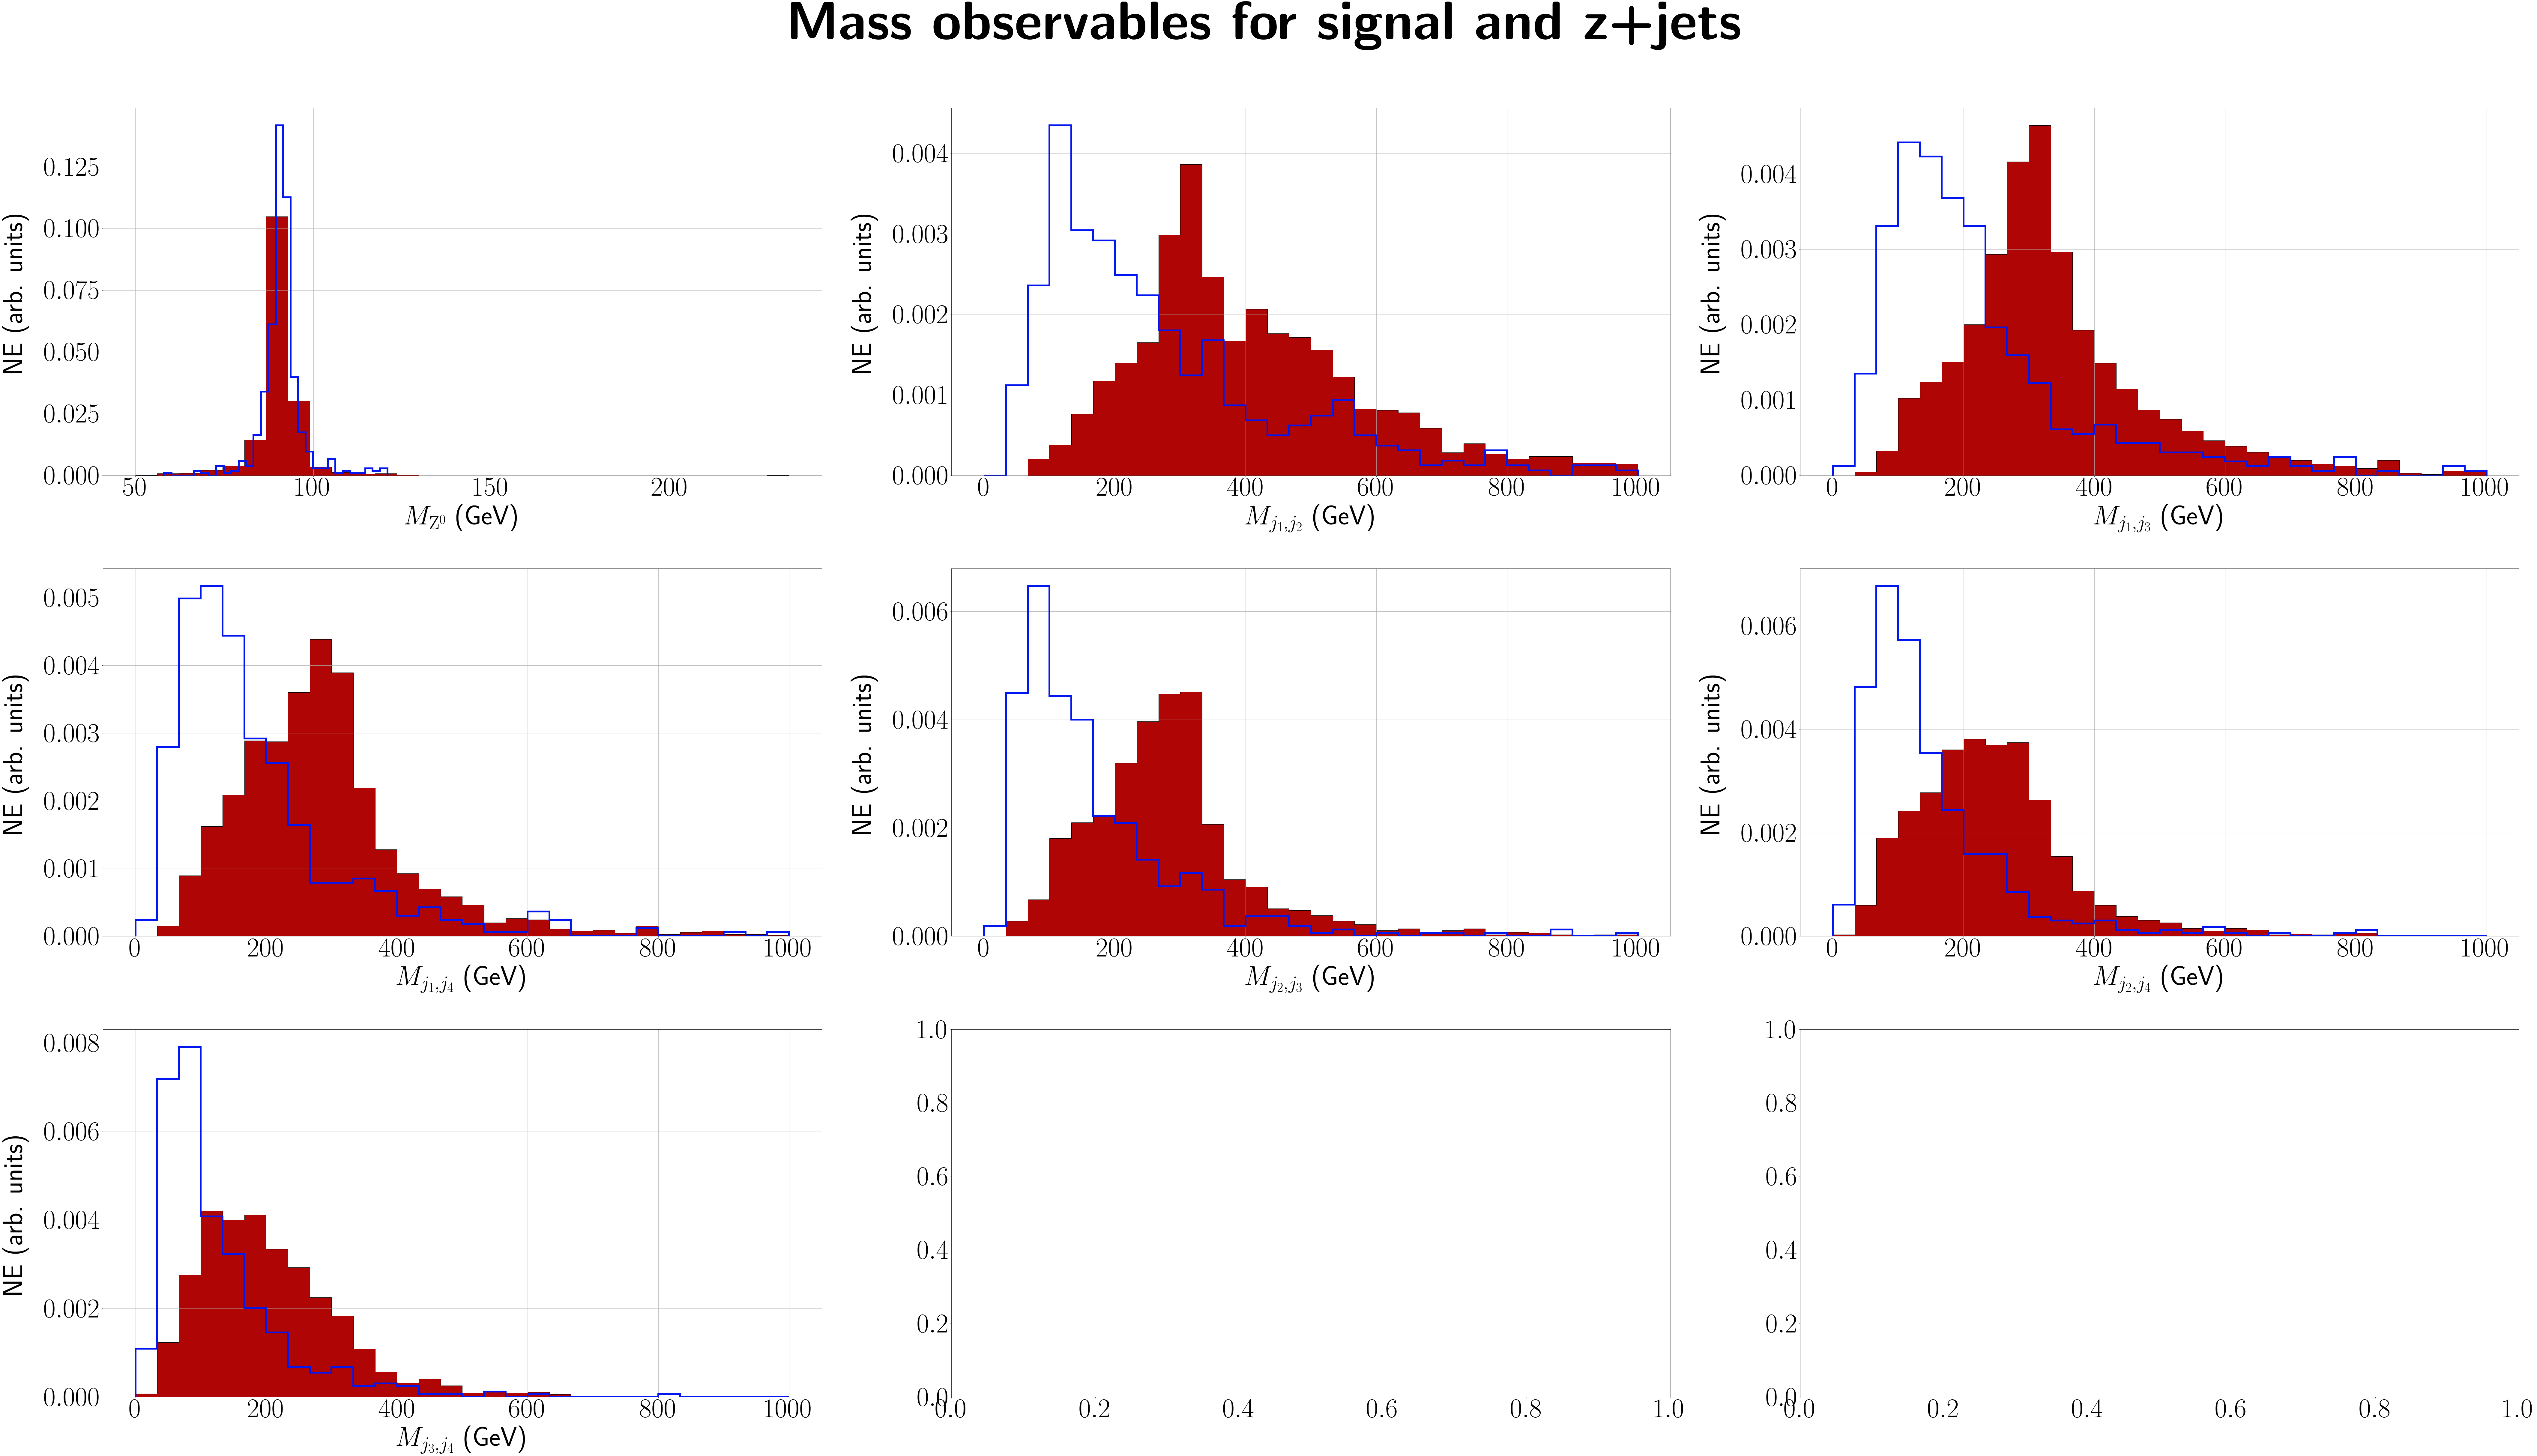

In [38]:
num_cols=3
N=len(labels)+1
fig, axes = plt.subplots(nrows=3,ncols=num_cols,figsize=(120,70))
fig.tight_layout(pad=5.0)
axes = axes.flatten()

for i, feature in enumerate(labels):

    var_signal = Signal.iloc[:,i]
    var_z_plus_jets = Z_plus_jets.iloc[:,i]
    if (feature == '$M_{j_1, j_2}$ (GeV)' or feature == '$M_{j_1, j_3}$ (GeV)' or feature == '$M_{j_1, j_4}$ (GeV)' or
       feature == '$M_{j_2, j_3}$ (GeV)' or feature == '$M_{j_3, j_4}$ (GeV)' or feature == '$M_{j_2, j_4}$ (GeV)'):
    
        var_signal.hist(ax=axes[i],range=(0,1000),bins=30,density=True,edgecolor='black',color='#b00505',histtype="stepfilled",label="Signal")
        var_z_plus_jets.hist(ax=axes[i],range=(0,1000),bins=30,density=True,edgecolor='#0216f0',color="#0216f0",histtype="step",label="$\\mathrm{Z^0+jets}$", linewidth=6.0)
        axes[i].set_xlabel(feature, labelpad = 10.0)
        axes[i].set_ylabel("NE (arb. units)", labelpad = 50.0)
    
    else:
        
        var_signal.hist(ax=axes[i],bins=30,density=True,edgecolor='black',color='#b00505',histtype="stepfilled",label="Signal")
        var_z_plus_jets.hist(ax=axes[i],bins=30,density=True,edgecolor='#0216f0',color="#0216f0",histtype="step",label="$\\mathrm{Z^0+jets}$", linewidth=6.0)
        axes[i].set_xlabel(feature, labelpad = 10.0)
        axes[i].set_ylabel("NE (arb. units)", labelpad = 50.0)
        
        
fig.suptitle('\\textbf{Mass observables for signal and z+jets}',fontsize=180) 
plt.tight_layout()
fig.subplots_adjust(top=0.91)
plt.savefig('//home/joao/Desktop/Root-analysis/1-BGL-MLProject/Plots/Mass_plots.pdf')
#plt.show()